## Required Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

## Helper Functions

In [2]:
def load_eurostat_tsv(path):
    """
    Load and clean a Eurostat-formatted TSV dataset.

    This function handles the specific structure used by Eurostat in `.tsv` files,
    where multiple metadata fields (e.g. freq, unit, geo) are embedded inside the
    first column separated by commas, and year values are spread across multiple
    wide-format columns.

    The function performs the following steps:
    - Reads the TSV file using tab separation.
    - Automatically detects and splits the composite metadata column into
      individual fields (e.g. 'freq', 'unit', 'c_resid', 'nace_r2', 'geo').
    - Renames Eurostat's encoded "geo\\TIME_PERIOD" field to a clean "geo".
    - Identifies year columns (four-digit names) and cleans their values:
        * Converts ":" into NaN.
        * Removes Eurostat suffixes ("e", "b", "p") indicating estimated,
          provisional, or series breaks.
        * Converts cleaned values to numeric.
    - Reorders columns so metadata fields appear first (geo, freq, c_resid,
      unit, nace_r2), followed by year columns.
    - Returns a tidy, analysis-ready DataFrame in wide format.

    Parameters
    ----------
    path : str
        Path to the Eurostat TSV file.

    Returns
    -------
    pandas.DataFrame
        A cleaned DataFrame where:
        - Metadata fields are split into separate columns.
        - The 'geo' column is properly extracted and placed first.
        - Year columns contain numeric values or NaN.
        - Non-numeric Eurostat artifacts and flags are removed.

    Notes
    -----
    - This function works with ANY Eurostat `.tsv` dataset based on the standard
      multi-dimension TSV export format (tourism, GDP, population density, etc.).
    - The output is kept in wide format for flexibility; use a melt/reshape
      helper for long-format needs.
    - Eurostat datasets often vary in the number of metadata fields included in
      the first column; this function dynamically adapts to those differences.
    """

    df = pd.read_csv(path, sep="\t")

    # 1. Detect and split the composite first column
    first_col = df.columns[0]
    meta_keys = first_col.split(",")

    df[meta_keys] = df[first_col].str.split(",", expand=True)
    df.drop(columns=[first_col], inplace=True)

    # 2. Rename geo\TIME_PERIOD → geo
    for col in df.columns:
        if col.startswith("geo"):
            df.rename(columns={col: "geo"}, inplace=True)
            break

    # 3. Clean year columns
    year_cols = [c for c in df.columns if re.match(r"^\d{4}$", str(c))]

    for col in year_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(":", np.nan)
            .str.replace(" e", "", regex=False)
            .str.replace(" b", "", regex=False)
            .str.replace(" p", "", regex=False)
        )

        df[col] = pd.to_numeric(df[col], errors="coerce")

    df.rename(columns={c: int(c) for c in year_cols}, inplace=True)

    # 4. Reorder: geo first
    meta_present = [c for c in ["geo", "freq", "c_resid", "unit", "nace_r2"] if c in df.columns]
    other_cols = [c for c in df.columns if c not in meta_present]

    df = df[meta_present + other_cols]

    return df

In [3]:
def eurostat_to_long(df, value_name):
    """
    Convert a cleaned Eurostat wide-format dataframe into long format.

    Parameters
    ----------
    df : pandas.DataFrame
        Output of load_eurostat_tsv()
    value_name : str
        Name of the metric column (e.g. 'nights_spent', 'gdp', 'pop_density')

    Returns
    -------
    pandas.DataFrame
        Long-format dataframe with columns: geo, year, <value_name>
    """

    # Identify year columns
    year_cols = [c for c in df.columns if isinstance(c, int)]

    # Melt
    long_df = df.melt(
        id_vars=["geo"],
        value_vars=year_cols,
        var_name="year",
        value_name=value_name
    )

    # Clean year column
    long_df["year"] = long_df["year"].astype(int)

    return long_df


In [4]:
def clean_year_columns(df):
    """
    Standardize Eurostat year column names.

    Cleans column names by removing spaces and Eurostat flags ('e', 'b', 'p'),
    and converts any 4-digit year strings (e.g. '2012', '2012 e') into integer
    column names. This ensures year columns are correctly detected when
    converting to long format.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame returned by load_eurostat_tsv().

    Returns
    -------
    pandas.DataFrame
        Same DataFrame with cleaned and integer-typed year columns.
    """
    fixed_cols = {}
    for col in df.columns:
        col_str = str(col).strip()              # remove spaces
        col_str = col_str.replace(" e", "")      # remove flags
        col_str = col_str.replace(" b", "")
        col_str = col_str.replace(" p", "")
        if col_str.isdigit() and len(col_str) == 4:
            fixed_cols[col] = int(col_str)
    df.rename(columns=fixed_cols, inplace=True)
    return df


In [5]:
def clean_nights(x):
    """
    Clean Eurostat tourism values by removing special flags and converting to numeric.

    Eurostat encodes missing or flagged values in strings such as:
    - ":"  → missing value
    - "e"  → estimated
    - "p"  → provisional
    - "b"  → break in series
    - "804181 e" → numeric value with an estimation flag

    This function:
    1. Removes spaces from strings.
    2. Converts ":" to None.
    3. Strips Eurostat flags ("e", "p", "b") from numeric strings.
    4. Attempts to convert cleaned values to float.
    5. Returns None if conversion is not possible.

    Parameters
    ----------
    x : str or number
        Raw Eurostat value from the tourism dataset.

    Returns
    -------
    float or None
        Clean numeric value, or None if the entry is missing or invalid.
    """
    if isinstance(x, str):
        x = x.replace(" ", "")
        if x == ":":
            return None
        x = x.replace("e", "").replace("p", "").replace("b", "")  # remove flags
    try:
        return float(x)
    except:
        return None


In [6]:
def clean_number(x):
    """
    Convert Eurostat-style numeric strings into floats.

    This function cleans values that may contain:
    - Missing markers (":" → treated as None)
    - Whitespace
    - Eurostat flags ("e", "p", "b"), which indicate estimated, provisional, or break in series

    After cleaning, the function attempts to convert the value to float.
    If conversion fails, it returns None.

    Parameters
    ----------
    x : any
        The value to clean and convert.

    Returns
    -------
    float or None
        Numeric value as float, or None if the input is missing or invalid.
    """
    if isinstance(x, str):
        x = x.replace(" ", "")
        if x == ":":
            return None
        x = x.replace("e", "").replace("p", "").replace("b", "")
    try:
        return float(x)
    except:
        return None

## Loading the Tourism Dataset (Target Variable)

### Nights spent at tourist accommodation establishments dataset.


---

### 📘 **Eurostat Variable Legend**

### **freq — Frequency**

* **A** → Annual
* **Q** → Quarterly
* **M** → Monthly


### **c_resid — Tourist Residency**

* **DOM** → Domestic tourists
* **FOR** → Foreign tourists
* **TOTAL** → All tourists combined


### **unit — Measurement Unit**

* **NR** → Number of nights
* **PC** → Percentage
* **PCH_PRE** → Percentage change compared to previous period
* **P_THAB** → Number of nights spent per thousand inhabitants
* **NRM** → Number in millions


### **nace_r2 — Accommodation Type**

* **I551** → Hotels
* **I552** → Holiday / short-stay accommodation
* **I553** → Camping grounds
* **I551_I552** → Hotels + holiday rentals
* **I552_I553** → Holiday rentals + camping
* **I551_I553** → All accommodation types
* **TOTAL** → Entire accommodation sector


### **geo — Geographic Identifier**

* **Country codes** → `AT`, `BE`, `FR`, `ES`, …
* **NUTS2 / NUTS3 regional codes** → `AT11`, `BE21`, `TR22`, `SI03`, `SK04`, …


### **TIME_PERIOD** (Year)

* Years from **1990–2024**
* Value represents:

  * Number of nights spent
  * Or (% change) depending on `unit`


### **Special Symbols**

* **`:`** → Missing value
* **`e`** → Estimated
* **`p`** → Provisional
* **`b`** → Break in time series

---

In [7]:
tourism_df = load_eurostat_tsv("raw_data/estat_tour_occ_nin2.tsv")
tourism_df

,geo,freq,c_resid,unit,nace_r2,1990,1991,1992,1993,1994,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,AL,A,DOM,NR,I551,:,:,:,:,:,...,:,:,:,804181 e,1015037 e,729659 e,1076608 e,1237862 e,1943039 e,2039675
1,AL0,A,DOM,NR,I551,:,:,:,:,:,...,:,:,:,804181 e,1015037 e,729659 e,1076608 e,1237862 e,1943039 e,2039675
2,AL01,A,DOM,NR,I551,:,:,:,:,:,...,:,:,:,199081 e,259910 e,148755 e,206227 e,261012 e,467356 e,501278
3,AL02,A,DOM,NR,I551,:,:,:,:,:,...,:,:,:,269005 e,329702 e,164554 e,245447 e,372722 e,514057 e,598752
4,AL03,A,DOM,NR,I551,:,:,:,:,:,...,:,:,:,336095 e,425425 e,416350 e,624934 e,604128 e,961626 e,939645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32259,UKM3,A,TOTAL,P_THAB,I551-I553,:,:,:,:,:,...,:,5324.41,:,:,:,:,:,:,:,:
32260,UKM5,A,TOTAL,P_THAB,I551-I553,:,:,:,:,:,...,8546.93,8436.02,:,:,:,:,:,:,:,:
32261,UKM6,A,TOTAL,P_THAB,I551-I553,:,:,:,:,:,...,10986.14,19337.05,:,:,:,:,:,:,:,:
32262,UKN,A,TOTAL,P_THAB,I551-I553,1443.35 e,:,:,:,1880,...,7341.56,7397.07,:,:,:,:,:,:,:,:


## Loading the GDP Dataset (Feature Variable)

---

## 📘 **GDP Dataset Legend (Eurostat — nama_10r_2gdp)**

### **freq — Frequency**

* **A** → Annual


### **unit — Measurement Unit**

* **MIO_EUR** → Millions of euros
* **EUR_HAB** → Euros per inhabitant
* **EUR** → Euros


### **nace_r2 — Indicator Code**

* **B1GQ** → GDP at market prices


### **geo — Geographic Identifier**

* **NUTS2 regional codes** (e.g., `ES51`, `DE21`, `ITC4`)

These represent the second administrative level in the EU statistical system.


### **TIME_PERIOD** (Year)

* Years available: **2000–2023**
* Value represents GDP in the specified measurement unit from `unit`.


### **Special Symbols**

* **`:`** → Missing value
* **`e`** → Estimated
* **`p`** → Provisional

---


In [8]:
gdp_df = load_eurostat_tsv("raw_data/estat_nama_10r_2gdp.tsv")
gdp_df

,geo,freq,unit,2000,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AL,A,EUR_HAB,:,:,:,:,:,:,:,...,3500,3600,3700,4000,4500,4800,4700,5400 p,:,:
1,AL0,A,EUR_HAB,:,:,:,:,:,:,:,...,3500,3600,3700,4000,4500,4800,4700,5400 p,:,:
2,AL01,A,EUR_HAB,:,:,:,:,:,:,:,...,2700,2900,3100,3300,3600,3900,3700,4300 p,:,:
3,AL02,A,EUR_HAB,:,:,:,:,:,:,:,...,4100,4300,4400,4900,5400,5800,5600,6500 p,:,:
4,AL03,A,EUR_HAB,:,:,:,:,:,:,:,...,3400,3300,3400,3600,4000,4400,4300,4900 p,:,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,TRB2,A,PPS_HAB_EU27_2020,:,:,:,:,15,16,17,...,25,26,26,26,25,24,25,22,25,28
3161,TRC,A,PPS_HAB_EU27_2020,:,:,:,:,21,21,22,...,33,34,33,33,31,29,32,31,36,38
3162,TRC1,A,PPS_HAB_EU27_2020,:,:,:,:,25,26,27,...,41,44,42,42,40,38,43,44,50,50
3163,TRC2,A,PPS_HAB_EU27_2020,:,:,:,:,20,20,21,...,27,28,27,27,24,23,24,22,26,29


## Population Dataset (feature variable)

---

## 📘 **Population Dataset Legend — *Population on 1 January by age, sex and NUTS-2 region (demo_r_d2jan)***

**Value meaning**

* Raw population count → number of inhabitants per NUTS-2 region at the beginning of the year

**freq**

* `A` — Annual data (population on January 1st)

**unit**

* `NR` — Number of persons (absolute population count)

**sex**

* `T` — Total population (male + female)
* `M` — Male population
* `F` — Female population

**age**

* `TOTAL` — Entire population (all ages)
* `Yxx` — Specific age (e.g., `Y20` = age 20)
* `Y_LT5` — Ages below 5
* `Y_GE90` — Ages 90+
  *(We keep only `TOTAL` for our model.)*

**geo**

* NUTS-2 regional code (e.g., `AT11`, `ES51`, `DE23`, `FRK2`)

**TIME_PERIOD / Year columns (1990–2024)**

* Each column contains the **population count** for that region in that year
* Values may include:

  * `:` — missing
  * `e` — estimated
  * `p` — provisional
  * `b` — break in series (e.g., boundary changes)

---


In [10]:
pop_df = load_eurostat_tsv("raw_data/estat_demo_r_d2jan.tsv")
pop_df

,geo,freq,unit,1990,1991,1992,1993,1994,1995,1996,...,2017,2018,2019,2020,2021,2022,2023,2024,sex,age
0,AL,A,NR,:,:,:,:,:,:,:,...,1423050,1431715,1432833,1425342,1419759,1406532,1394864,:,F,TOTAL
1,AL0,A,NR,:,:,:,:,:,:,:,...,1423050,1431715,1432833,1425342,1419759,1406532,1394864,:,F,TOTAL
2,AL01,A,NR,:,:,:,:,:,:,:,...,405835,405598,404201,399599,396799,390886,385462,:,F,TOTAL
3,AL02,A,NR,:,:,:,:,:,:,:,...,574010,585530,590623,594008,596005,597622,598531,:,F,TOTAL
4,AL03,A,NR,:,:,:,:,:,:,:,...,443205,440587,438009,431735,426955,418024,410871,:,F,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160570,UKM7,A,NR,:,:,:,:,:,:,:,...,343,323,303,:,:,:,:,:,T,Y_OPEN
160571,UKM8,A,NR,:,:,:,:,:,:,:,...,229,210,193,:,:,:,:,:,T,Y_OPEN
160572,UKM9,A,NR,:,:,:,:,:,:,:,...,159,160,151,:,:,:,:,:,T,Y_OPEN
160573,UKN,A,NR,:,:,17566,17934,18214,18456,18763,...,281,282,:,:,:,:,:,:,T,Y_OPEN


# 📘 Employment Dataset (estat_lfst_r_lfe2emprt.tsv) — (feature variable)

This dataset provides **annual employment rates (%)** for each **NUTS-2 region in Europe**, broken down by **sex**, **age group**, **frequency**, and **measurement unit**.

### **Columns Reference**

| Column                       | Meaning                                                                                                                                                                                                                                                  |
| ---------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **geo**                      | NUTS-2 region code (e.g., `AT11`, `ES51`, `FR10`)                                                                                                                                                                                                        |
| **freq**                     | Frequency of data collection. Always **A = Annual**                                                                                                                                                                                                      |
| **unit**                     | Unit of measure. Here always **PC = Percent (%)** — employment *rate*, not absolute numbers                                                                                                                                                              |
| **sex**                      | `M` (male), `F` (female), `T` (total)                                                                                                                                                                                                                    |
| **age**                      | Employment rate age group (e.g., `Y15-24`, `Y_GE65`, `Y20-64`, or `TOTAL`)                                                                                                                                                                               |
| **year columns (1999…2024)** | Employment rate in **percent** for each year. Values like `45.1b` may include Eurostat flags: <br> • `b` = break in series <br> • `u` = low reliability <br> • `p` = provisional <br> • `e` = estimated <br> These must be removed during preprocessing. |                                                                                                                                                                                                                      |

---

In [11]:
empl_df = load_eurostat_tsv("raw_data/estat_lfst_r_lfe2emprt.tsv")
empl_df

,geo,freq,unit,1999,2000,2001,2002,2003,2004,2005,...,2017,2018,2019,2020,2021,2022,2023,2024,sex,age
0,AT,A,PC,50.7,48.6,47.2,47.7,46.4,45.1 b,48.5 b,...,49.0,48.7,48.4,47.8,45.7 b,48.2,49.8,48.3,F,Y15-24
1,AT1,A,PC,49.9,46.3,44.4,45.1,42.3,41.9 b,43.9 b,...,45.3,44.2,42.5,43.3,40.9 b,42.7,44.9,44.3,F,Y15-24
2,AT11,A,PC,51.6,49.2,45.4 u,42.9 u,46.9 u,47.1 bu,46.4 b,...,41.3 u,41.5 u,41.3 u,38.3 u,40.5 bu,46.0 u,45.3 u,47.0,F,Y15-24
3,AT12,A,PC,52.6,49.7,47.4,47.0,44.3,44.9 b,47.7 b,...,50.7,46.4,46.9,49.1,47.1 b,46.7,51.6,46.9,F,Y15-24
4,AT13,A,PC,46.7,42.1,41.1,43.5,39.4,38.0 b,39.8 b,...,41.4,42.8,39.1,39.3,36.1 b,39.2,39.9,42.0,F,Y15-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18427,UKM7,A,PC,:,:,:,:,:,:,:,...,8.9,7.3,7.4,:,:,:,:,:,T,Y_GE65
18428,UKM8,A,PC,:,:,:,:,:,:,:,...,7.8,8.0,7.9,:,:,:,:,:,T,Y_GE65
18429,UKM9,A,PC,:,:,:,:,:,:,:,...,9.9,5.9,7.0,:,:,:,:,:,T,Y_GE65
18430,UKN,A,PC,6.4 bu,5.8 u,4.8 u,5.8 u,6.5 u,: bu,6.1 b,...,8.9,10.3,10.1,:,:,:,:,:,T,Y_GE65


## Cleaning year columns

In [14]:
tourism_df = clean_year_columns(tourism_df)
gdp_df = clean_year_columns(gdp_df)
pop_df = clean_year_columns(pop_df)
empl_df = clean_year_columns(empl_df)


## Converting Dataframes to Long Format

In [15]:
tourism_long = eurostat_to_long(tourism_df, value_name="nights_spent")
gdp_long = eurostat_to_long(gdp_df, value_name="gdp")
pop_long = eurostat_to_long(pop_df, value_name="pop")
empl_long = eurostat_to_long(empl_df, value_name="employment")


### 🔍 Filtering the Tourism Dataset

The tourism dataset contains many variables (percentages, km²-normalized values, foreign-only values, etc.).  
Here, we extract **only the data we need** for the target variable:

- `unit == "NR"` → we keep *absolute number of nights spent*  
- `c_resid == "TOTAL"` → includes both domestic and foreign tourists  
- `nace_r2` containing `"I551"`, `"I552"`, `"I553"` → selects valid accommodation types  
  (hotels, holiday/short-stay, camping, or combined categories)

This ensures we keep only rows representing **real nights spent in tourist accommodations**,  
not ratios, percentages, or incomplete subsets.


In [16]:
tourism_df_filtered = tourism_df[
    (tourism_df["unit"] == "NR") &              # Nights spent
    (tourism_df["c_resid"] == "TOTAL") &        # Total residents (domestic + foreign)
    (
        tourism_df["nace_r2"].str.contains("I551") |
        tourism_df["nace_r2"].str.contains("I552") |
        tourism_df["nace_r2"].str.contains("I553")
    )
].copy()

# Remove rows where all years are missing
year_cols = [c for c in tourism_df_filtered.columns if isinstance(c, int)]
tourism_df_filtered = tourism_df_filtered.dropna(subset=year_cols, how="all")

# Converting the dataset into Long format
tourism_long = eurostat_to_long(tourism_df_filtered, "nights_spent")

# Removing missing target values
tourism_long = tourism_long.dropna(subset=["nights_spent"])

In [17]:
# Remove rows where all years are missing
year_cols = [c for c in tourism_df_filtered.columns if isinstance(c, int)]
tourism_df_filtered = tourism_df_filtered.dropna(subset=year_cols, how="all")


In [18]:
# Converting the dataset into Long format
tourism_long = eurostat_to_long(tourism_df_filtered, "nights_spent")


In [19]:
# Removing missing target values
tourism_long = tourism_long.dropna(subset=["nights_spent"])

In [20]:
tourism_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144165 entries, 0 to 144164
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   geo           144165 non-null  object
 1   year          144165 non-null  int64 
 2   nights_spent  144165 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


In [21]:
print("Remaining units:", tourism_df_filtered["unit"].unique())
print("Remaining resid:", tourism_df_filtered["c_resid"].unique())
print("Remaining accom:", tourism_df_filtered["nace_r2"].unique())
print("Rows:", len(tourism_df_filtered))


Remaining units: ['NR']
Remaining resid: ['TOTAL']
Remaining accom: ['I551' 'I551-I553' 'I552' 'I552_I553' 'I553']
Rows: 4119


### 💶 Filtering the GDP Dataset

The GDP dataset contains multiple units and indicators.  
Here we extract only the variable we want to use as a feature:

- `unit == "EUR_HAB"` → GDP per inhabitant (comparable across regions)

Steps:
1. Clean Eurostat’s year-column names (`clean_year_columns`).
2. Keep only rows corresponding to **GDP per inhabitant**.
3. Remove regions where *all* year values are missing.
4. Convert the dataset from **wide format** (one column per year)  
   to **long format** (`geo`, `year`, `gdp`).
5. Remove rows where GDP is still missing.

In [22]:
gdp_df = clean_year_columns(gdp_df)

In [23]:
gdp_df = clean_year_columns(gdp_df)

gdp_df_filtered = gdp_df[gdp_df["unit"] == "EUR_HAB"].copy()

year_cols = [c for c in gdp_df_filtered.columns if isinstance(c, int)]
gdp_df_filtered = gdp_df_filtered.dropna(subset=year_cols, how="all")

gdp_long = eurostat_to_long(gdp_df_filtered, "gdp")
gdp_long = gdp_long.dropna(subset=["gdp"])

gdp_long


,geo,year,gdp
0,AL,2000,:
1,AL0,2000,:
2,AL01,2000,:
3,AL02,2000,:
4,AL03,2000,:
...,...,...,...
10507,TRB2,2023,4800
10508,TRC,2023,6300
10509,TRC1,2023,8300
10510,TRC2,2023,4900


## 👥 Filtering the Total Population Dataset

This dataset provides **NUTS-2 total population (1990–2024)**.

We keep only:

* `unit = NR` → absolute population numbers
* `sex = T` → total population (all genders)
* `age = TOTAL` → whole age range

Then:

* Remove regions with no valid yearly data
* Reshape from wide → long (`geo`, `year`, `pop`)
* Keep only rows with valid population values


In [24]:
# Clean year columns (convert strings to numbers, remove ":" etc.)
pop_df = clean_year_columns(pop_df)

# Keep only total population values
pop_df_filtered = pop_df[
    (pop_df["unit"] == "NR") &        # absolute number of persons
    (pop_df["sex"] == "T") &          # total population (male + female)
    (pop_df["age"] == "TOTAL")        # entire age range
].copy()

# Remove rows where ALL year-columns are missing
year_cols = [c for c in pop_df_filtered.columns if isinstance(c, int)]
pop_df_filtered = pop_df_filtered.dropna(subset=year_cols, how="all")

# Convert from wide → long format
pop_long = eurostat_to_long(pop_df_filtered, "pop")

# Remove rows with missing population
pop_long = pop_long.dropna(subset=["pop"])

pop_long


,geo,year,pop
0,AL,1990,3286500
1,AL0,1990,3286500
2,AL01,1990,:
3,AL02,1990,:
4,AL03,1990,:
...,...,...,...
18230,UKM7,2024,:
18231,UKM8,2024,:
18232,UKM9,2024,:
18233,UKN,2024,:


# 🛠 Filtering the Employment Dataset

We keep **one clean employment rate per NUTS-2 region per year**, applying these rules:

* **unit == "PC"** → employment *rate* in %
* **sex == "T"** → total population (male + female combined)
* **age == "Y20-64"** or **age == "TOTAL"**

  > The typical Eurostat employment rate (headline labour market indicator) is for **ages 20–64**.
  > If you prefer TOTAL, adjust accordingly.

---

In [28]:
# Clean year columns (convert strings like "45.2b" → 45.2, ":" → NaN)
empl_df = clean_year_columns(empl_df)

# Keep only employment rate (percent), total sex, and correct age group
empl_df_filtered = empl_df[
    (empl_df["unit"] == "PC") &      # percent
    (empl_df["sex"] == "T") &        # total population (male + female)
    (empl_df["age"] == "Y20-64")     # headline indicator age group
].copy()

# Remove rows where ALL year columns are missing
year_cols = [c for c in empl_df_filtered.columns if isinstance(c, int)]
empl_df_filtered = empl_df_filtered.dropna(subset=year_cols, how="all")

# Convert wide → long format
empl_long = eurostat_to_long(empl_df_filtered, "employment_rate")

# Remove missing values
empl_long = empl_long.dropna(subset=["employment_rate"])

empl_long

,geo,year,employment_rate
0,AT,1999,70.9
1,AT1,1999,71.4
2,AT11,1999,70.3
3,AT12,1999,71.2
4,AT13,1999,71.7
...,...,...,...
13307,UKM7,2024,:
13308,UKM8,2024,:
13309,UKM9,2024,:
13310,UKN,2024,:


In [30]:
df = tourism_long.merge(gdp_long, on=["geo", "year"], how="inner")
df = df.merge(pop_long, on=["geo", "year"], how="inner")
df = df.merge(empl_long, on=["geo", "year"], how="inner")

df

,geo,year,nights_spent,gdp,pop,employment_rate
0,AT,2000,71648851,26500,8002186,70.7
1,AT1,2000,12521784,28200,3359846,71.0
2,AT11,2000,1401744,17700,276226,70.8
3,AT12,2000,3862628,21900,1535083,71.8
4,AT13,2000,7257412,36400,1548537,70.2
...,...,...,...,...,...,...
51955,TRB2,2023,:,4800,2157272,46.9
51956,TRC,2023,:,6300,9305910,46.7
51957,TRC1,2023,:,8300,2937139,50.6
51958,TRC2,2023,:,4900,3974990,44.7


### 📅 Restricting the Tourism Dataset to Years With Valid Data

Eurostat reports nights-spent data inconsistently across earlier decades.  
To avoid carrying large portions of missing data, we determine the **earliest year**  
that contains at least one valid `nights_spent` entry.

We then filter the dataset to keep only years **>= this minimum valid year**.

This step reduces noise and ensures all remaining rows correspond to years  
where the variable actually exists.

In [31]:
min_valid_year = tourism_long[tourism_long["nights_spent"].notna()]["year"].min()
tourism_long = tourism_long[tourism_long["year"] >= min_valid_year]

tourism_long

,geo,year,nights_spent
0,AL,1990,:
1,AL0,1990,:
2,AL01,1990,:
3,AL02,1990,:
4,AL03,1990,:
...,...,...,...
144160,UKM3,2024,:
144161,UKM5,2024,:
144162,UKM6,2024,:
144163,UKN,2024,:


### 🧼 Cleaning `nights_spent` (Removing Eurostat Flags and Missing Symbols)

We use helper function `clean_nights()` to clean our target variable `nights_spent`


In [32]:
tourism_long["nights_spent"] = tourism_long["nights_spent"].apply(clean_nights)

### 🔗 Final Merge: Tourism × GDP × Population Density

We now merge the three cleaned long-format datasets:

- `tourism_long` → Target variable `nights_spent`
- `gdp_long` → GDP per inhabitant
- `pop_long` → Population density

We merge on:
- `geo` (NUTS-2 region code)
- `year`

We use **inner joins** to ensure we keep only region-year pairs  
that exist in *all* datasets.

The resulting table contains:

| geo | year | nights_spent | gdp | pop_density |

In [33]:
df = tourism_long.merge(gdp_long, on=["geo", "year"], how="inner")
df = df.merge(pop_long, on=["geo", "year"], how="inner")
df = df.merge(empl_long, on=["geo", "year"], how="inner")

df

,geo,year,nights_spent,gdp,pop,employment_rate
0,AT,2000,71648851.0,26500,8002186,70.7
1,AT1,2000,12521784.0,28200,3359846,71.0
2,AT11,2000,1401744.0,17700,276226,70.8
3,AT12,2000,3862628.0,21900,1535083,71.8
4,AT13,2000,7257412.0,36400,1548537,70.2
...,...,...,...,...,...,...
51955,TRB2,2023,NaN,4800,2157272,46.9
51956,TRC,2023,NaN,6300,9305910,46.7
51957,TRC1,2023,NaN,8300,2937139,50.6
51958,TRC2,2023,NaN,4900,3974990,44.7


In [34]:
# Removing Rows Without Tourism Data (Missing Target Variable)
df_clean = df.dropna(subset=["nights_spent"])

# Move target variable to the last column
cols = [c for c in df_clean.columns if c != "nights_spent"] + ["nights_spent"]
df_clean = df_clean[cols]

## Final Cleaned Merged Dataset (GDP + population + employment + tourism)

In [35]:
df_clean

,geo,year,gdp,pop,employment_rate,nights_spent
0,AT,2000,26500,8002186,70.7,71648851.0
1,AT1,2000,28200,3359846,71.0,12521784.0
2,AT11,2000,17700,276226,70.8,1401744.0
3,AT12,2000,21900,1535083,71.8,3862628.0
4,AT13,2000,36400,1548537,70.2,7257412.0
...,...,...,...,...,...,...
51940,TR63,2023,7800,3422884,46.7,1007.0
51941,TR7,2023,8900,4124939,55.1,348.0
51942,TR71,2023,8900,1630050,54.5,348.0
51953,TRB,2023,5800,3928271,49.3,1108.0


## HeatMap Data Visualization

### Quick Heatmap correlation visualization of the current data of the final dataset

In [37]:
data_corr = df_clean.drop(columns="geo").copy()

# Apply the cleaning function to numeric columns
for col in ["gdp", "pop", "employment_rate"]:
    data_corr[col] = data_corr[col].apply(clean_number).astype(float)


<Axes: >

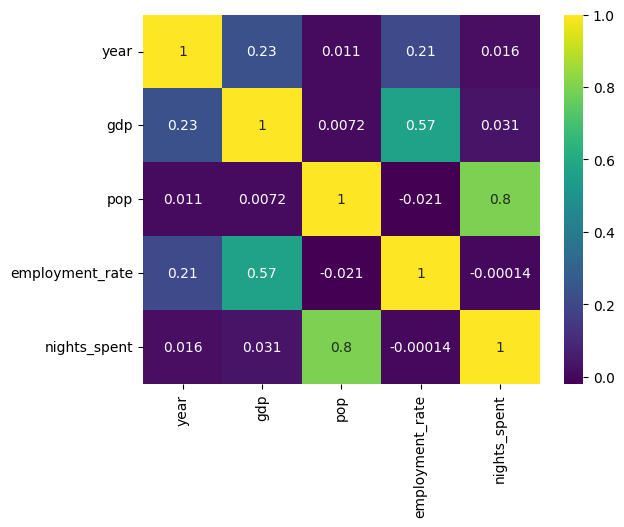

In [38]:
sns.heatmap(data_corr.corr(), annot=True, cmap="viridis")